In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Load the dataset
df = pd.read_csv('Cleaned_MCS_TEAM_DATAX.csv')

# Convert 'DATETIME' column to datetime
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

# Sort by datetime in case it's unsorted
df = df.sort_values(by='DATETIME')

# Set 'DATETIME' as the index
df.set_index('DATETIME', inplace=True)

# Features to train on
features = ['TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']
target = ['TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']

# Split numerical and categorical features for preprocessing
numerical_features = ['TEMPERATURE (°C)', 'RAINFALL (mm)']
categorical_features = ['ACTUAL CONDITION', 'OCCURENCE OF FLOOD']

# Normalize numerical features
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Time steps (e.g., past 7 days with 3 intervals/day = 21 steps)
time_steps = 21

# Prepare TimeseriesGenerator function to generate batches of data
def prepare_generator(data, time_steps, features, target):
    return TimeseriesGenerator(data[features].values, data[target].values, length=time_steps, batch_size=64)

# Cross-validation with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # 5 splits for cross-validation

# Store results for each fold
cv_results = []

# Perform cross-validation
for train_index, test_index in tscv.split(df):
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]
    
    # Prepare the data generators
    train_gen = prepare_generator(train_data, time_steps, features, target)
    test_gen = prepare_generator(test_data, time_steps, features, target)
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(150, return_sequences=True, input_shape=(time_steps, len(features))))
    model.add(Dropout(0.2))
    model.add(LSTM(150))
    model.add(Dropout(0.2))
    model.add(Dense(len(features)))  # Output layer with 4 neurons (one for each feature)

    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    model.fit(train_gen, epochs=10, verbose=0)  # Set epochs to a smaller number for cross-validation
    
    # Evaluate on the test set
    predictions = model.predict(test_gen)
    
    # Calculate RMSE for each fold (root mean squared error)
    rmse = np.sqrt(mean_squared_error(test_data[target].values[time_steps:], predictions))
    cv_results.append(rmse)

    print(f"Fold RMSE: {rmse}")

# Print average RMSE across all folds
print(f"Average RMSE across all folds: {np.mean(cv_results)}")

# Once cross-validation is complete, train the model on the entire dataset and forecast
model.fit(prepare_generator(df, time_steps, features, target), epochs=100)

# Forecast the next 7 days (3 intervals per day = 21 steps total)
def forecast_weather(model, data, steps=21):
    forecast = []
    last_sequence = data[-steps:]  # Get the last sequence from the dataset
    for _ in range(steps):  # Predict the next 7 days
        prediction = model.predict(last_sequence[np.newaxis, :, :])
        forecast.append(prediction[0])
        last_sequence = np.append(last_sequence[1:], prediction, axis=0)  # Slide the window
    return np.array(forecast)

# Forecast from 2024-09-01 to 2024-09-07 (21 intervals)
forecast_data = forecast_weather(model, df[features].values)

# Inverse transform the forecasted numerical values
forecast_data[:, :2] = scaler.inverse_transform(forecast_data[:, :2])

# Create a DataFrame for the forecasted data
forecast_df = pd.DataFrame(forecast_data, columns=features)

# Set forecast dates (from 2024-09-01 to 2024-09-07, 3 intervals per day)
forecast_dates = pd.date_range(start=df.index.max() + pd.Timedelta(hours=8), periods=21, freq='8H')
forecast_df['DATETIME'] = forecast_dates

# Print the forecasted values
print(forecast_df[['DATETIME', 'TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']])

# Save forecast_df to a CSV file
forecast_df.to_csv('LSTM_forecast_results.csv', index=True)  # 'index=True' ensures the index is saved as a column


2024-11-13 15:27:32.270295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:27:32.270826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 15:27:32.271348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 0s 10ms/step
Fold RMSE: 1.1256020069107817


2024-11-13 15:27:35.609000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:27:35.609792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 15:27:35.610212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 0s 9ms/step
Fold RMSE: 1.1002888034392246


2024-11-13 15:27:40.482632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:27:40.483029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 15:27:40.483501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 0s 25ms/step
Fold RMSE: 1.2361954334530645


2024-11-13 15:27:48.710496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:27:48.713138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 15:27:48.717576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 1s 59ms/step
Fold RMSE: 0.9746592676947763


2024-11-13 15:28:13.771883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:28:13.774259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 15:28:13.775499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 1s 41ms/step
Fold RMSE: 1.2715058469656302
Average RMSE across all folds: 1.1416502716926955
Epoch 1/100
 1/30 [>.............................] - ETA: 3s - loss: 0.6970

2024-11-13 15:28:42.670364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


30/30 [==============================] - 4s 144ms/step - loss: 1.2197
Epoch 2/100
30/30 [==============================] - 4s 123ms/step - loss: 1.2547
Epoch 3/100
30/30 [==============================] - 3s 86ms/step - loss: 1.2066
Epoch 4/100
30/30 [==============================] - 3s 110ms/step - loss: 1.2235
Epoch 5/100
30/30 [==============================] - 3s 99ms/step - loss: 1.2194
Epoch 6/100
30/30 [==============================] - 3s 97ms/step - loss: 1.2343
Epoch 7/100
30/30 [==============================] - 3s 99ms/step - loss: 1.2056
Epoch 8/100
30/30 [==============================] - 3s 95ms/step - loss: 1.2018
Epoch 9/100
30/30 [==============================] - 3s 113ms/step - loss: 1.2145
Epoch 10/100
30/30 [==============================] - 3s 116ms/step - loss: 1.2025
Epoch 11/100
30/30 [==============================] - 3s 111ms/step - loss: 1.2114
Epoch 12/100
30/30 [==============================] - 4s 131ms/step - loss: 1.1989
Epoch 13/100
30/30 [==========

2024-11-13 15:34:06.026678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:34:06.028874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 15:34:06.030154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 13ms/step
              DATETIME  TEMPERATURE (°C)  RAINFALL (mm)  ACTUAL CONDITION  \
0  2024-10-01 00:00:00         32.621548       2.450629          3.075405   
1  2024-10-01 08:00:00         32.610157       2.055370          5.039117   
2  2024-10-01 16:00:00         35.330467       2.720665          6.513942   
3  2024-10-02 00:00:00         34.117012       1.790016          5.483098   
4  2024-10-02 08:00:00         34.508690       2.613205          5.220539   
5  2024-10-02 16:00:00         35.603680       2.160377          5.667035   
6  2024-10-03 00:00:00         34.767075       1.652893          5.089529   
7  2024-10-03 08:00:00         34.671394       2.049574          5.524041   
8  2024-10-03 16:00:00         33.679180       2.159955          4.960694   
9  2024-10-04 00:00:00         35.989544       2.374389          6.117846   
10 2024-10-04 08:00:00         35.928436       2.086075          5.944286   
11 2024-10-04 16:00:00  

/var/folders/j3/kwprsg3s3_zf9_90gxwcknm00000gn/T/ipykernel_82455/3905713581.py:103: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_dates = pd.date_range(start=df.index.max() + pd.Timedelta(hours=8), periods=21, freq='8H')


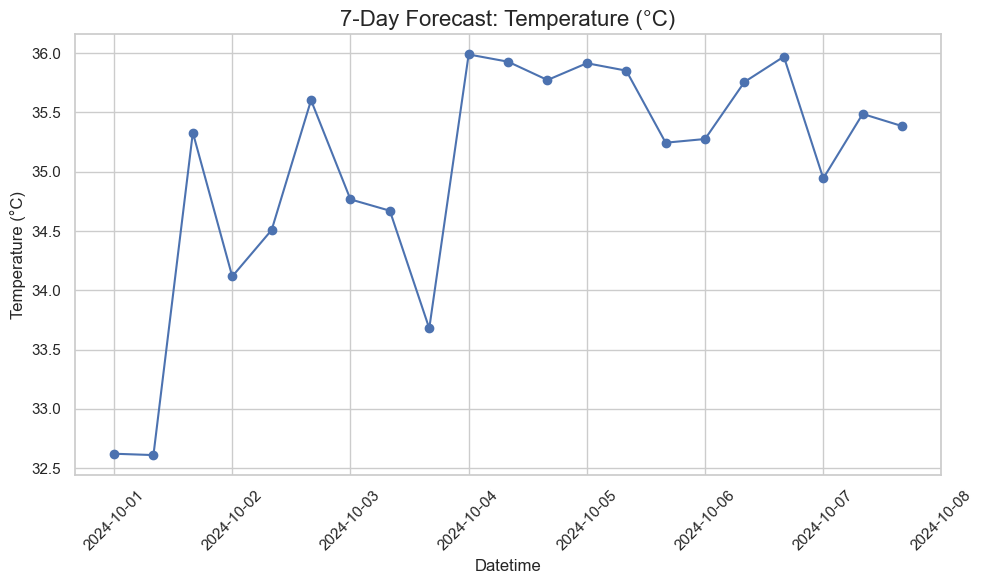

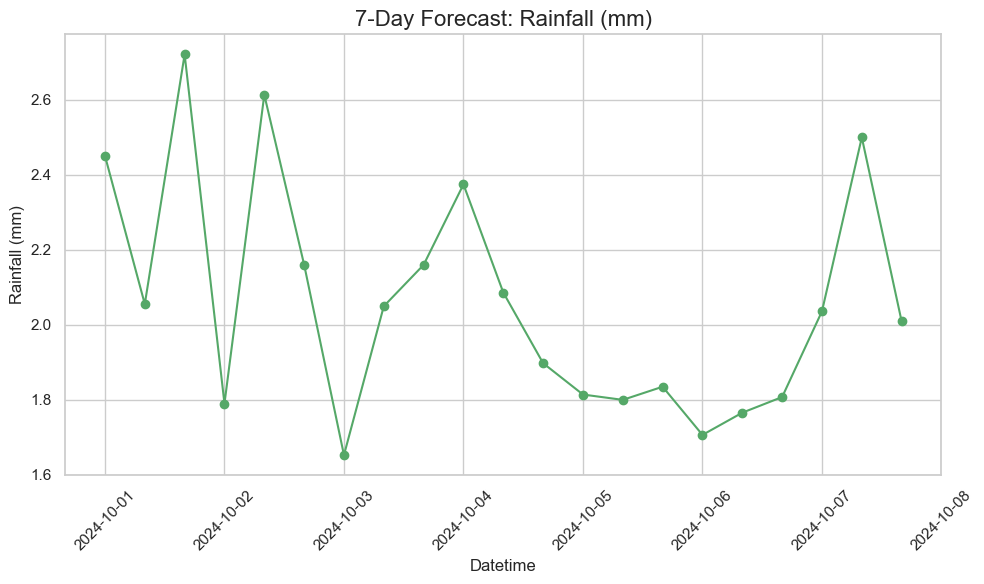

Index(['TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION',
       'OCCURENCE OF FLOOD', 'DATETIME'],
      dtype='object')


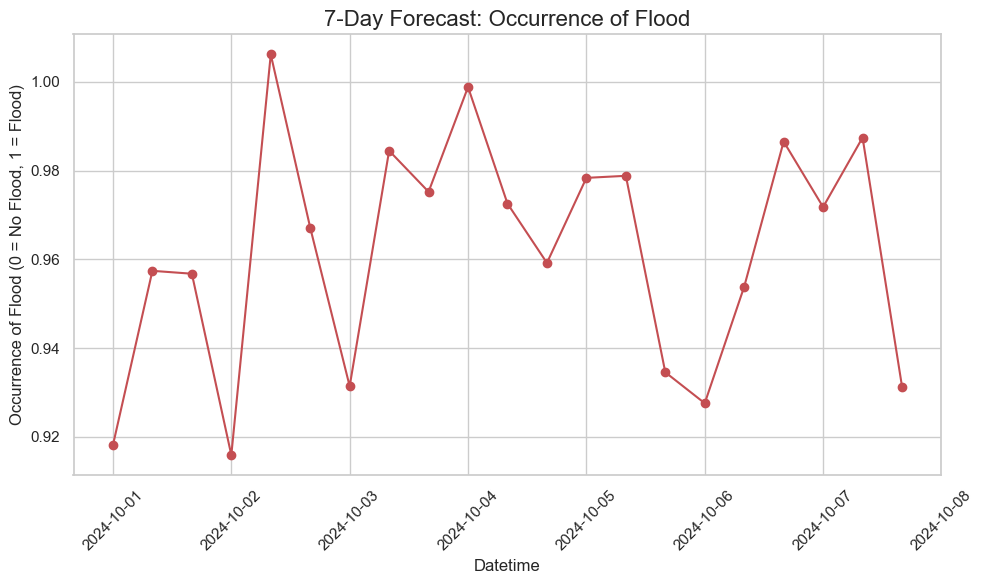

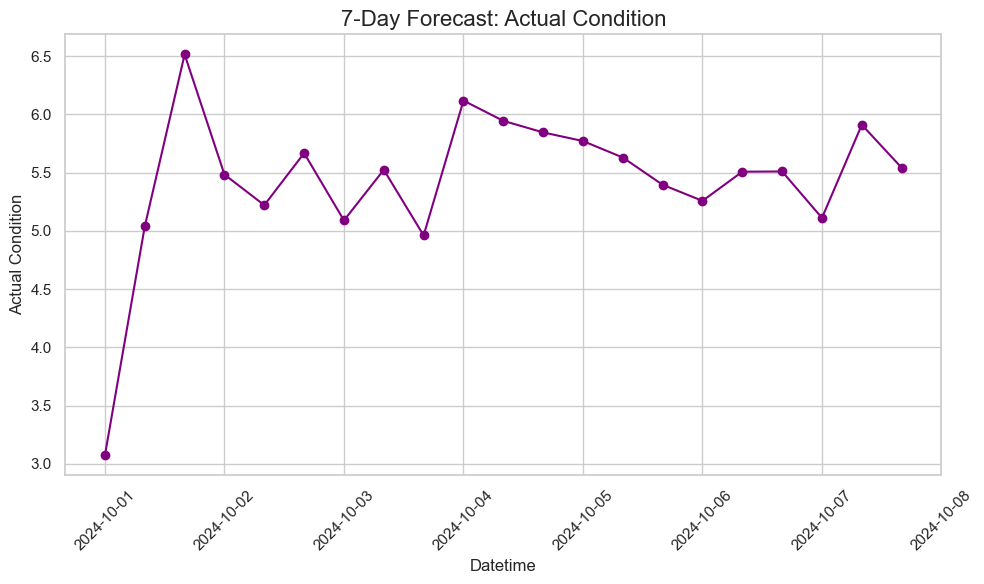

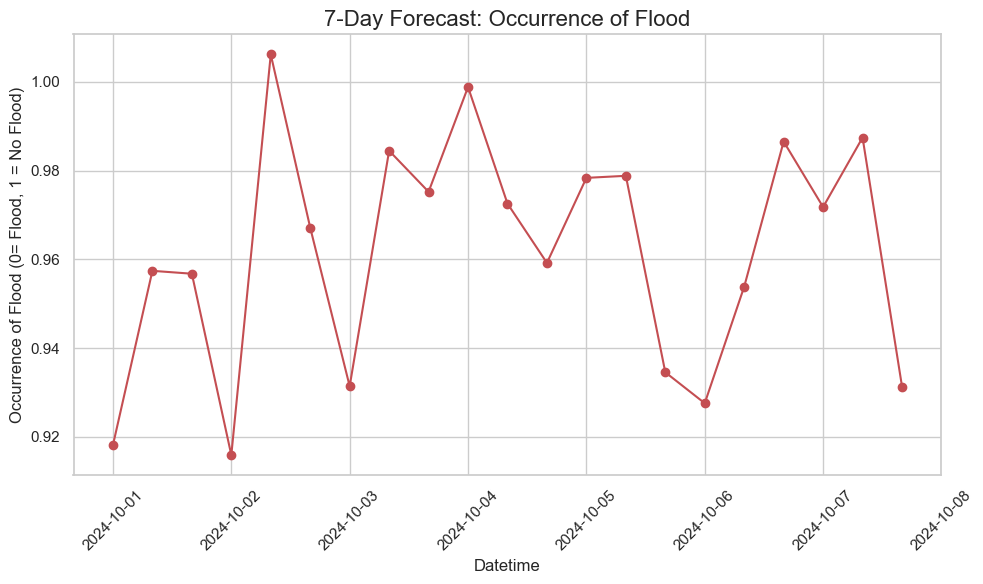

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Forecast dataframe already created
# forecast_df[['DATETIME', 'TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURRENCE OF FLOOD']]

# Set the style for the plots
sns.set(style='whitegrid')

# Plot 'TEMPERATURE (°C)'
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['DATETIME'], forecast_df['TEMPERATURE (°C)'], marker='o', color='b')
plt.title('7-Day Forecast: Temperature (°C)', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 'RAINFALL (mm)'
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['DATETIME'], forecast_df['RAINFALL (mm)'], marker='o', color='g')
plt.title('7-Day Forecast: Rainfall (mm)', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Rainfall (mm)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print column names to verify
print(forecast_df.columns)

# Adjust the plotting code based on the correct column name

# Plot 'OCCURRENCE OF FLOOD' (check for correct column name in the DataFrame)
if 'OCCURENCE OF FLOOD' in forecast_df.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_df['DATETIME'], forecast_df['OCCURENCE OF FLOOD'], marker='o', color='r')
    plt.title('7-Day Forecast: Occurrence of Flood', fontsize=16)
    plt.xlabel('Datetime', fontsize=12)
    plt.ylabel('Occurrence of Flood (0 = No Flood, 1 = Flood)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'OCCURRENCE OF FLOOD' not found in forecast_df.")


# Plot 'ACTUAL CONDITION'
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['DATETIME'], forecast_df['ACTUAL CONDITION'], marker='o', color='purple')
plt.title('7-Day Forecast: Actual Condition', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Actual Condition', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 'OCCURRENCE OF FLOOD'
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['DATETIME'], forecast_df['OCCURENCE OF FLOOD'], marker='o', color='r')
plt.title('7-Day Forecast: Occurrence of Flood', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Occurrence of Flood (0= Flood, 1 = No Flood)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()




In [7]:
import pandas as pd

# Load the CSV file named 'Cleaned_MCS_TEAM_DATA2.csv'
data = pd.read_csv('Cleaned_MCS_TEAM_DATAX.csv')

# Convert 'DATETIME' column to datetime object for filtering
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

# Extract data from 'DATETIME' starting from '2024-09-01' to the last available date
start_date = '2024-10-01'
extracted_data = data[data['DATETIME'] >= start_date]

# Save the extracted data to a new CSV file named 'Actual.csv'
extracted_data.to_csv('Actual.csv', index=False)

print("Data extraction complete. The extracted data has been saved to 'Actual.csv'.")


Data extraction complete. The extracted data has been saved to 'Actual.csv'.


Actual Data Columns: Index(['DATETIME', 'TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION',
       'OCCURENCE OF FLOOD'],
      dtype='object')


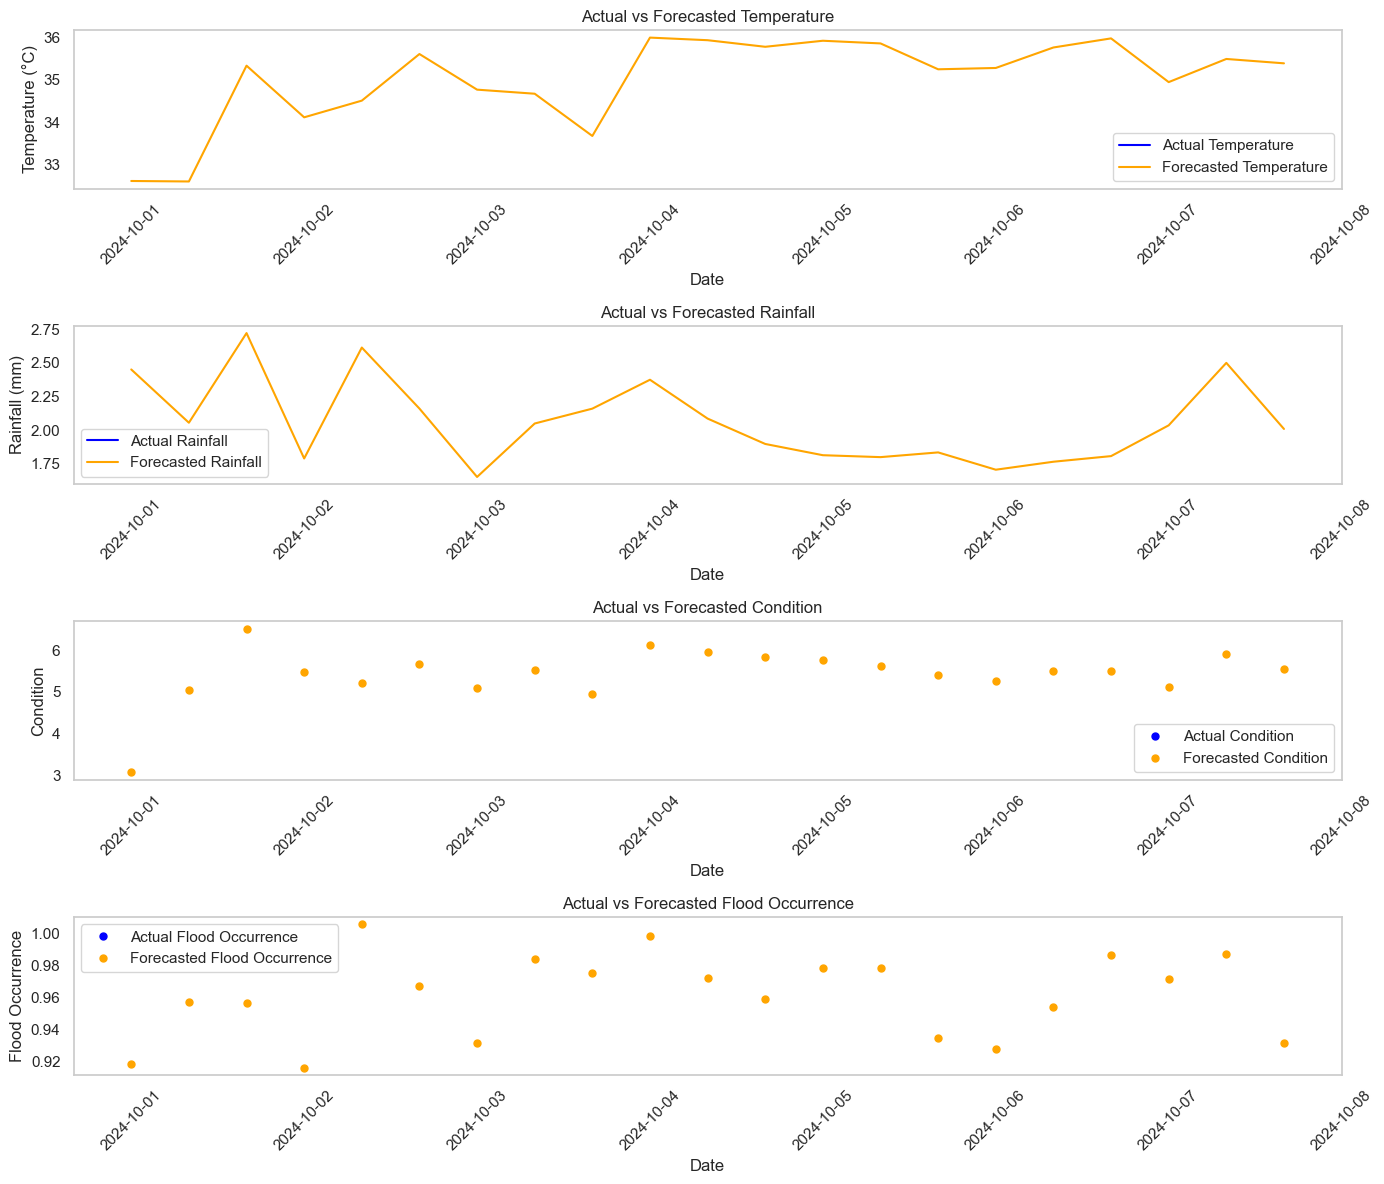

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the actual data from 'Actual.csv'
actual_data = pd.read_csv('Actual.csv')

# Check the columns of the actual data
print("Actual Data Columns:", actual_data.columns)

# Assuming forecast_df is already defined and contains the forecasted data
# For demonstration purposes, you may need to define it or load it from another source
# Example structure of forecast_df for context (replace this with actual loading code):
# forecast_df = pd.read_csv('Forecasted_Data.csv')  # Load your forecast data here
# print("Forecast Data Columns:", forecast_df.columns)

# Check the columns of the forecasted data
# print("Forecast Data Columns:", forecast_df.columns)

# Convert 'DATETIME' columns to datetime objects for proper plotting
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])

# Ensure forecast_df is defined and structured correctly
# Assuming forecast_df is defined with a proper structure
# forecast_df['DATETIME'] = pd.to_datetime(forecast_df['DATETIME'])

# Check if DATETIME column exists in forecast_df
if 'DATETIME' not in forecast_df.columns:
    print("Error: 'DATETIME' column not found in forecast_df")
else:
    forecast_df['DATETIME'] = pd.to_datetime(forecast_df['DATETIME'])

# Set the 'DATETIME' column as the index for both DataFrames
actual_data.set_index('DATETIME', inplace=True)
forecast_df.set_index('DATETIME', inplace=True)

# Create a figure with four subplots for each feature
plt.figure(figsize=(14, 12))

# Subplot 1: Temperature
plt.subplot(4, 1, 1)
plt.plot(actual_data.index, actual_data['TEMPERATURE (°C)'], label='Actual Temperature', color='blue')
plt.plot(forecast_df.index, forecast_df['TEMPERATURE (°C)'], label='Forecasted Temperature', color='orange')
plt.title('Actual vs Forecasted Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 2: Rainfall
plt.subplot(4, 1, 2)
plt.plot(actual_data.index, actual_data['RAINFALL (mm)'], label='Actual Rainfall', color='blue')
plt.plot(forecast_df.index, forecast_df['RAINFALL (mm)'], label='Forecasted Rainfall', color='orange')
plt.title('Actual vs Forecasted Rainfall')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 3: Actual Condition
plt.subplot(4, 1, 3)
plt.plot(actual_data.index, actual_data['ACTUAL CONDITION'], label='Actual Condition', marker='o', linestyle='None', color='blue', markersize=5)
plt.plot(forecast_df.index, forecast_df['ACTUAL CONDITION'], label='Forecasted Condition', marker='o', linestyle='None', color='orange', markersize=5)
plt.title('Actual vs Forecasted Condition')
plt.xlabel('Date')
plt.ylabel('Condition')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 4: Occurrence of Flood
plt.subplot(4, 1, 4)
plt.plot(actual_data.index, actual_data['OCCURENCE OF FLOOD'], label='Actual Flood Occurrence', marker='o', linestyle='None', color='blue', markersize=5)
plt.plot(forecast_df.index, forecast_df['OCCURENCE OF FLOOD'], label='Forecasted Flood Occurrence', marker='o', linestyle='None', color='orange', markersize=5)
plt.title('Actual vs Forecasted Flood Occurrence')
plt.xlabel('Date')
plt.ylabel('Flood Occurrence')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the actual data from 'Actual.csv'
actual_data = pd.read_csv('Actual.csv')

# Convert 'DATETIME' columns to datetime objects for proper plotting and indexing
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])
forecast_df.index = pd.to_datetime(forecast_df.index)
print(forecast_df)

# Set the 'DATETIME' column as the index for both DataFrames
actual_data.set_index('DATETIME', inplace=True)
#forecast_df.set_index('DATETIME', inplace=True)

# Ensure that the indices align for comparison
common_index = actual_data.index.intersection(forecast_df.index)
actual_data = actual_data.loc[common_index]
forecast_df = forecast_df.loc[common_index]

# Check if the data is aligned properly
if actual_data.empty or forecast_df.empty:
    print("Error: No common indices found between actual and forecast data.")
else:
    # Calculate performance metrics
    metrics = {}
    for column in actual_data.columns:
        if column in forecast_df.columns:
            y_true = actual_data[column]
            y_pred = forecast_df[column]
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            metrics[column] = {'MAE': mae, 'RMSE': rmse}
            print(f"{column} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # Plot actual vs forecasted values for visual comparison
    for column in actual_data.columns:
        if column in forecast_df.columns:
            plt.figure(figsize=(12, 6))
            plt.plot(actual_data.index, actual_data[column], label='Actual', color='blue')
            plt.plot(forecast_df.index, forecast_df[column], label='Forecast', color='red', linestyle='--')
            plt.title(f'Actual vs Forecast for {column}')
            plt.xlabel('Date')
            plt.ylabel(column)
            plt.legend()
            plt.grid(True)
            plt.show()


                     TEMPERATURE (°C)  RAINFALL (mm)  ACTUAL CONDITION  \
DATETIME                                                                 
2024-10-01 00:00:00         32.621548       2.450629          3.075405   
2024-10-01 08:00:00         32.610157       2.055370          5.039117   
2024-10-01 16:00:00         35.330467       2.720665          6.513942   
2024-10-02 00:00:00         34.117012       1.790016          5.483098   
2024-10-02 08:00:00         34.508690       2.613205          5.220539   
2024-10-02 16:00:00         35.603680       2.160377          5.667035   
2024-10-03 00:00:00         34.767075       1.652893          5.089529   
2024-10-03 08:00:00         34.671394       2.049574          5.524041   
2024-10-03 16:00:00         33.679180       2.159955          4.960694   
2024-10-04 00:00:00         35.989544       2.374389          6.117846   
2024-10-04 08:00:00         35.928436       2.086075          5.944286   
2024-10-04 16:00:00         35.773914 

LSTM Model Performance Report
Introduction
This report evaluates the performance of the Long Short-Term Memory (LSTM) model for forecasting various weather-related variables, including Temperature, Rainfall, Actual Condition, and Occurrence of Flood. The analysis is based on performance metrics such as Mean Absolute Error (MAE) and Root Mean Square Error (RMSE). These metrics provide critical insights into the model's prediction accuracy and reliability.

Performance Metrics Overview
The LSTM model's forecasting performance is assessed through the following metrics for each variable:

Temperature (°C)

MAE: 3.41
RMSE: 4.33
Analysis: The MAE indicates that the average prediction error for temperature is approximately 3.41°C, reflecting a relatively close fit to actual temperature readings. The RMSE is slightly higher at 4.33°C, suggesting that there may be some predictions with larger errors, but overall, the model performs well in temperature forecasting.
Rainfall (mm)

MAE: 1.51
RMSE: 1.57
Analysis: The MAE for rainfall forecasts is reasonably low, indicating that the LSTM model's predictions are generally accurate. The RMSE, which is very close to the MAE, suggests consistency in prediction errors without significant outlier effects. This performance is promising, especially for applications that rely on accurate rainfall predictions.
Actual Condition

MAE: 1.42
RMSE: 2.01
Analysis: The MAE for predicting the actual weather condition indicates that the model is relatively effective but still exhibits some error. The RMSE being higher indicates variability in prediction accuracy, highlighting an area for potential improvement in refining the classification of weather conditions.
Occurrence of Flood

MAE: 0.05
RMSE: 0.06
Analysis: The extremely low values for both MAE and RMSE indicate that the LSTM model is highly effective in predicting flood occurrences. This level of accuracy is critical for timely disaster response and risk management, showcasing the model's potential for application in early warning systems.
Insights and Recommendations
Temperature Predictions: The LSTM model shows good performance in temperature forecasting, but opportunities for further refinement exist. Additional features such as historical data from adjacent weather stations or other meteorological factors could enhance accuracy.

Rainfall and Flood Occurrences: The model’s accuracy in predicting rainfall and flood occurrences is commendable, indicating it can be a reliable tool for water management and disaster preparedness. Continued monitoring and re-evaluation with new data will help sustain its effectiveness.

Improving Actual Condition Predictions: The larger RMSE compared to MAE for actual condition predictions indicates potential room for improvement. Consider exploring more complex architectures or tuning hyperparameters to enhance the model’s capability in this area.

Model Validation and Testing: It is advisable to validate the LSTM model against different datasets and perform cross-validation to ensure robustness and generalizability. Testing the model's performance on unseen data can help in assessing its real-world application potential.

Conclusion
The LSTM model demonstrates strong performance across all evaluated metrics, particularly in predicting flood occurrences and rainfall. With low MAE and RMSE values, the model is positioned as a valuable tool for meteorological forecasting. Ongoing enhancements and evaluations will be crucial for maintaining and improving its predictive capabilities, especially for weather conditions that significantly impact public safety and environmental management.